In [1]:
import pandas as pd
import numpy as np

In [2]:
def delete_marks(x):
    if x is None:
        return x
    
    if x[0] == '"': x = x[1:]
    if x[-1] == '"': x = x[:-1]
    return x

In [3]:
data = pd.read_csv("./data/ufodata.txt", sep='" "', engine='python')
data.reset_index(drop=True, inplace=True)

data["Posted"] = data["Posted"].apply(delete_marks)
data.head()

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/17/11 06:30,Partlow,VA,Flash,About a min,Went out to have a smoke ....looking up to see...,12/17/11
1,12/16/11 23:45,Bellevue,WA,Light,5 sec,Man witnesses a strange green lights streak ve...,12/17/11
2,12/16/11 22:59,Cooksville,MD,Sphere,5 minutes,"4 glowing orange spherical objects viewed, fly...",12/17/11
3,12/16/11 21:40,Deltona,FL,Triangle,unknown,"Triangular shaped object, with a rounded back ...",12/17/11
4,12/16/11 21:30,Atlantic Ocean (in flight),NaN,Light,5 minutes,Crew of Lear jet over the Atlantic Ocean repor...,12/17/11


In [4]:
import scipy.stats as stats

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [5]:
resumetable(data)

Dataset Shape: (68721, 7)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Date / Time,object,1,60303,12/17/11 06:30,12/16/11 23:45,12/16/11 22:59,15.77
1,City,object,156,19452,Partlow,Bellevue,Cooksville,12.63
2,State,object,6450,71,VA,WA,MD,5.20
3,Shape,object,2654,46,Flash,Light,Sphere,3.82
4,Duration,object,2835,10104,About a min,5 sec,5 minutes,9.40
5,Summary,object,34,68378,Went out to have a smoke ....looking up to see...,Man witnesses a strange green lights streak ve...,"4 glowing orange spherical objects viewed, fly...",16.06
6,Posted,object,3,255,12/17/11,12/17/11,12/17/11,7.35


In [6]:
print(data['Summary'][0],
      data['Summary'][1],
      data['Summary'][2], sep='\n *** \n')

Went out to have a smoke ....looking up to see if mars was out and and noticed a bright star in the north east .... Then what I thought
 *** 
Man witnesses a strange green lights streak vertically down in eastern sky.
 *** 
4 glowing orange spherical objects viewed, flying in some type of formation.


Похоже у нас данные очевидцев НЛО!

In [7]:
# Обработка времени
from datetime import datetime
from dateutil.relativedelta import relativedelta


def str_to_date(x):
    if x is None:
        return None
    
    if 5 <= len(x) <= 8:
        date = datetime.strptime(x, "%m/%d/%y")
    if 9 <= len(x):
        date = datetime.strptime(x, "%m/%d/%y %H:%M")
        
    if date > datetime(2021, 1, 1):
        date -= relativedelta(years=100)
    return date


if type(data['Date / Time'][0]) is str:
    data['Date / Time'] = [str_to_date(str_timr) for str_timr in data['Date / Time']]
    data['Posted'] = [str_to_date(str_timr) for str_timr in data['Posted']]

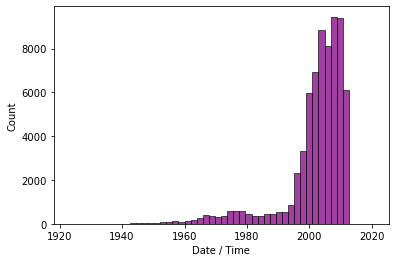

In [8]:
import seaborn as sns

# Видим, что после 1990 года НЛО стало чаще посещать нашу планету
sns.histplot(data['Date / Time'], bins=50, color='purple');

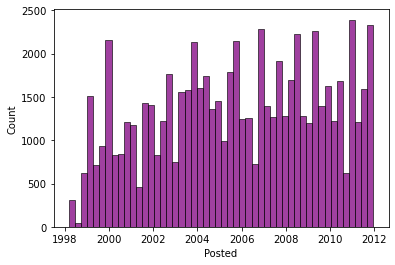

In [9]:
# Особой тенденции здесь не наблюдается
sns.histplot(data['Posted'], bins=50, color='purple');

In [97]:
from scipy.stats import kstest, chisquare

# Проверим data['Posted'] на равномерное распределение от 1998 до 2011, 
# так как в 2012 только 3 наблюдения и это похоже на то, что был сбор данных в начале года
Posted_years = data['Posted'].apply(lambda x: x.year).to_numpy()
Posted_years = Posted_years[Posted_years < 2012].astype(int)

# посмотрим на тест колмогорова и тест хи квадрат.
# Для хи квадрат находим количество встреч каждого года и 
# H0: p_i = 1/13 (13 лет)
print(chisquare(np.bincount(Posted_years - min(Posted_years))))

# Тестируем H0
# H0: data ~ U[1998, 2011]
print(kstest((Posted_years - 1998)/13, 'uniform'))

# В двух случаях отвергаем гипотезу о равномерном распределении.

Power_divergenceResult(statistic=5194.052853691902, pvalue=0.0)
KstestResult(statistic=0.12088535754824065, pvalue=0.0)


Самые часто встречаемые города

In [98]:
data['City'].value_counts()[:5]

Seattle        481
Phoenix        407
Los Angeles    322
Portland       310
Las Vegas      309
Name: City, dtype: int64

Самые часто встречаемые штаты

In [99]:
data['State'].value_counts()[:5]

CA    8457
WA    3740
TX    3387
FL    3242
NY    2726
Name: State, dtype: int64

Посмотрим в какое время люди чаще всего встречали НЛО. 

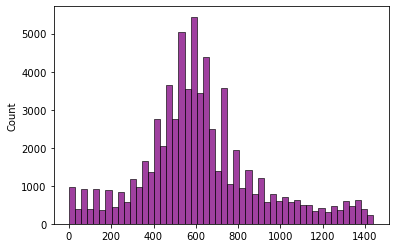

In [228]:
date = pd.DatetimeIndex(data['Date / Time'])
minutes = (date.minute + date.hour * 60).to_numpy()
minutes[24572] = 0
minutes_after_12_am = np.where(minutes < 12*60, minutes + 12*60, minutes - 12*60)


sns.histplot(minutes_after_12_am, bins=50, color='purple');

Видим цикличные пики. Скорее всего люди приблизительно отмечали либо 00, либо 30 минут. Тогда посмотрим график по часам

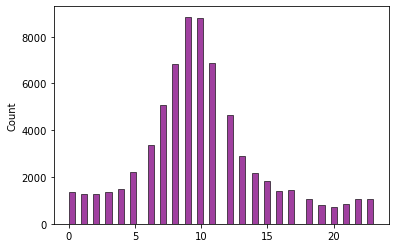

In [240]:
date = pd.DatetimeIndex(data['Date / Time'])
hours = date.hour.to_numpy().astype(float)
hours[24572] = 0
hours_after_12_am = np.where(hours < 12, hours + 12, hours-12)
sns.histplot(hours_after_12_am, bins=50, color='purple');

Так же видим, что люди часто отмечали 12 часов в качестве приблизительного значения

In [264]:
# Тестируем H0
# H0: data ~ Ласпласса с beta = 10, alpha = 0.6
print(kstest((hours_after_12_am - 10) / 4.7, 'laplace'))

KstestResult(statistic=0.11382472255806353, pvalue=0.0)


Расмотрим, как среднее время для самых популярных для НЛО городов отличается

In [272]:
ca_index = data['State'] == 'CA'
wa_index = data['State'] == 'WA'
tx_index = data['State'] == 'TX'
fl_index = data['State'] == 'FL'

for name, index in zip(['CA', 'WA', 'TX', 'FL'], [ca_index, wa_index, tx_index, fl_index]):
    avg_time = np.median(minutes[index])
    print(f'Average(median) time is between 12 am and time of the meeting in minutes in {name} state - {avg_time}')
    

Average(median) time is between 12 am and time of the meeting in minutes in CA state - 1140.0
Average(median) time is between 12 am and time of the meeting in minutes in WA state - 1165.0
Average(median) time is between 12 am and time of the meeting in minutes in TX state - 1140.0
Average(median) time is between 12 am and time of the meeting in minutes in FL state - 1152.5


In [277]:
from scipy.stats import kruskal

# H0: Все медианы равны
_, p = kruskal(minutes[ca_index], minutes[wa_index], minutes[tx_index], minutes[fl_index])

if p > 0.05:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Different distributions (reject H0)


In [275]:
# Отвергаем нулвеую гипотезу о равенстве средних в случае медиан